In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [4]:
# Загрузка данных
df = pd.read_csv('loan_approval_dataset.csv')

# Посмотрим на данные
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

print("\nСтатистика по числовым колонкам:")
print(df.describe())

print("\nПроверка пропущенных значений:")
print(df.isnull().sum())

print("\nРаспределение целевой переменной:")
print(df['loan_status'].value_counts())
print(df['loan_status'].value_counts(normalize=True))

Размер датасета: (4269, 13)

Первые 5 строк:
   loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0              

In [38]:
# Разделение на признаки и целевую переменную
X = df.drop(['loan_id', 'loan_status'], axis=1)
y = df['loan_status']

# Преобразование категориальных признаков
categorical_cols = ['education', 'self_employed']
numerical_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
                  'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                  'luxury_assets_value', 'bank_asset_value']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [29]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# функция для оценки и визуализации результатов модели
def evaluate_model(model, name):
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)

    # точность
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    cr = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(cr)

    # визуализация матрицы ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

    return accuracy, cm, cr


Лучшие параметры для логистической регрессии:
{'classifier__C': 0.01, 'classifier__solver': 'liblinear'}

--- Логистическая регрессия ---
Accuracy: 0.9141

Confusion Matrix:
[[751  59]
 [ 51 420]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.94      0.93      0.93       810
    Rejected       0.88      0.89      0.88       471

    accuracy                           0.91      1281
   macro avg       0.91      0.91      0.91      1281
weighted avg       0.91      0.91      0.91      1281



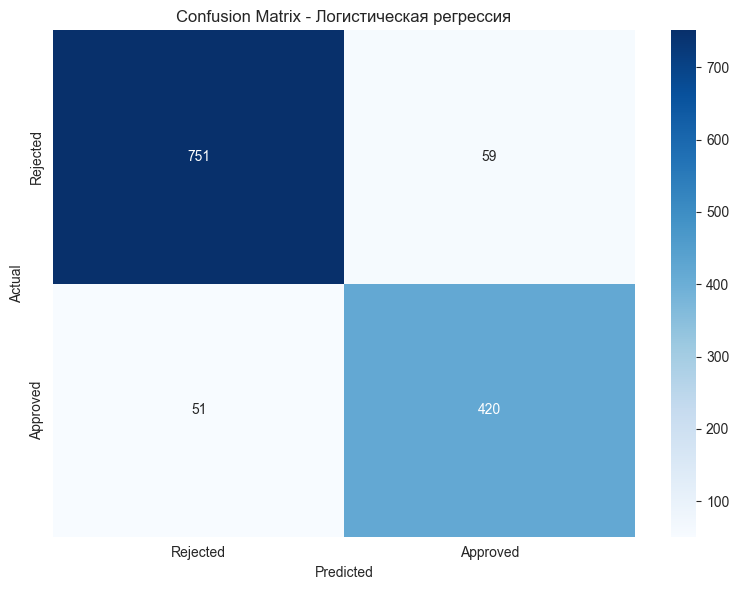

In [39]:
# 1. логистическая регрессия
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear']
}

lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)

print("\nЛучшие параметры для логистической регрессии:")
print(lr_grid.best_params_)
lr_accuracy, lr_cm, lr_cr = evaluate_model(lr_grid, "Логистическая регрессия")


Лучшие параметры для наивного байесовского классификатора (Бернулли):
{'classifier__alpha': np.float64(0.01), 'classifier__binarize': 0.0, 'classifier__fit_prior': True}

--- Наивный байесовский классификатор (Бернулли) ---
Accuracy: 0.8454

Confusion Matrix:
[[614 196]
 [  2 469]]

Classification Report:
              precision    recall  f1-score   support

    Approved       1.00      0.76      0.86       810
    Rejected       0.71      1.00      0.83       471

    accuracy                           0.85      1281
   macro avg       0.85      0.88      0.84      1281
weighted avg       0.89      0.85      0.85      1281



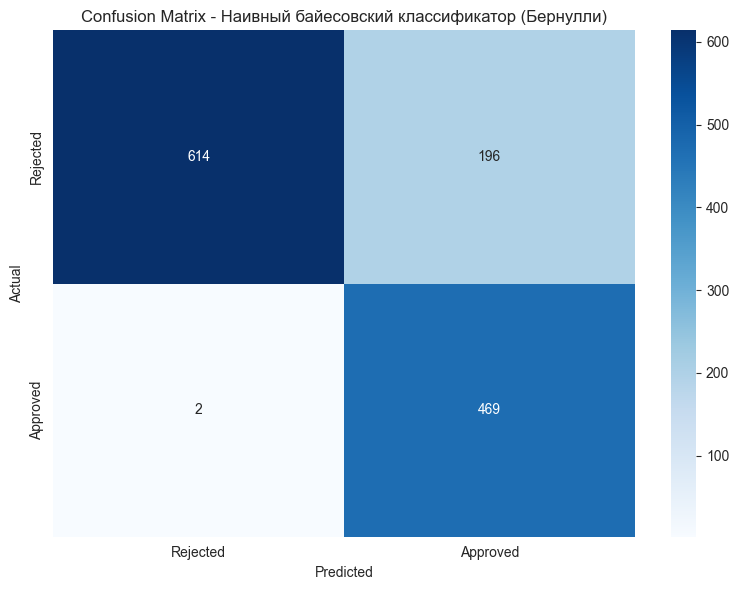

In [40]:
# 2. наивный байесовский классификатор (Бернулли)
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB())
])

nb_param_grid = {
    'classifier__alpha': np.logspace(-2, 2, 10),
    'classifier__binarize': [0.0, 0.5, 1.0],
    'classifier__fit_prior': [True, False]
}

nb_grid = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring='accuracy')
nb_grid.fit(X_train, y_train)

print("\nЛучшие параметры для наивного байесовского классификатора (Бернулли):")
print(nb_grid.best_params_)
nb_accuracy, nb_cm, nb_cr = evaluate_model(nb_grid, "Наивный байесовский классификатор (Бернулли)")


Лучшие параметры для SVM:
{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

--- Support Vector Machine ---
Accuracy: 0.9352

Confusion Matrix:
[[765  45]
 [ 38 433]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.95      0.94      0.95       810
    Rejected       0.91      0.92      0.91       471

    accuracy                           0.94      1281
   macro avg       0.93      0.93      0.93      1281
weighted avg       0.94      0.94      0.94      1281



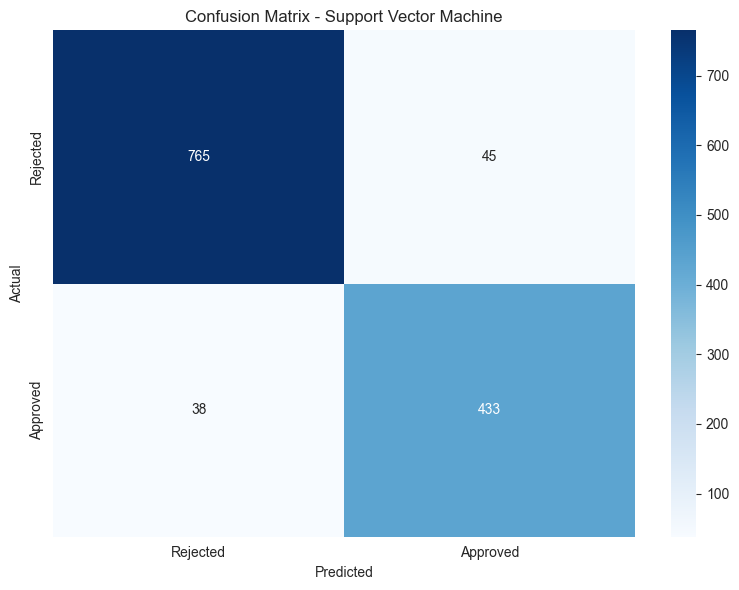

In [41]:
# 3. метод опорных векторов (SVM)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto', 0.1, 1]
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)

print("\nЛучшие параметры для SVM:")
print(svm_grid.best_params_)
svm_accuracy, svm_cm, svm_cr = evaluate_model(svm_grid, "Support Vector Machine")


Лучшие параметры для дерева решений:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

--- Дерево решений ---
Accuracy: 0.9750

Confusion Matrix:
[[799  11]
 [ 21 450]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.97      0.99      0.98       810
    Rejected       0.98      0.96      0.97       471

    accuracy                           0.98      1281
   macro avg       0.98      0.97      0.97      1281
weighted avg       0.98      0.98      0.97      1281



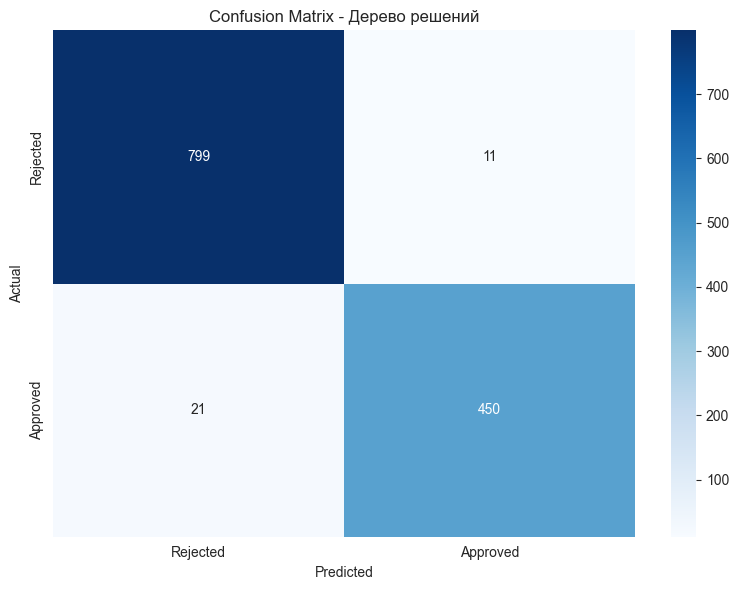

In [42]:
# 4. дерево решений
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

print("\nЛучшие параметры для дерева решений:")
print(dt_grid.best_params_)
dt_accuracy, dt_cm, dt_cr = evaluate_model(dt_grid, "Дерево решений")


Лучшие параметры для случайного леса:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

--- Случайный лес ---
Accuracy: 0.9789

Confusion Matrix:
[[802   8]
 [ 19 452]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.98       810
    Rejected       0.98      0.96      0.97       471

    accuracy                           0.98      1281
   macro avg       0.98      0.97      0.98      1281
weighted avg       0.98      0.98      0.98      1281



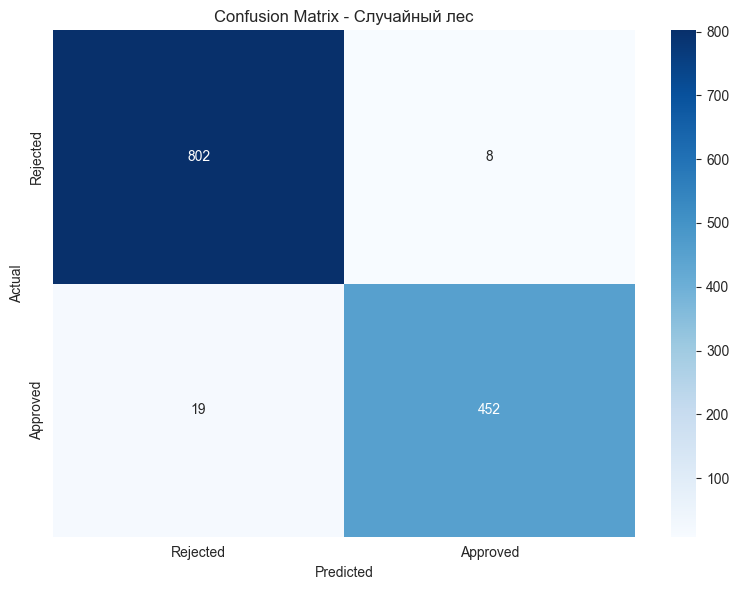

In [43]:
# 5. случайный лес
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

print("\nЛучшие параметры для случайного леса:")
print(rf_grid.best_params_)
rf_accuracy, rf_cm, rf_cr = evaluate_model(rf_grid, "Случайный лес")

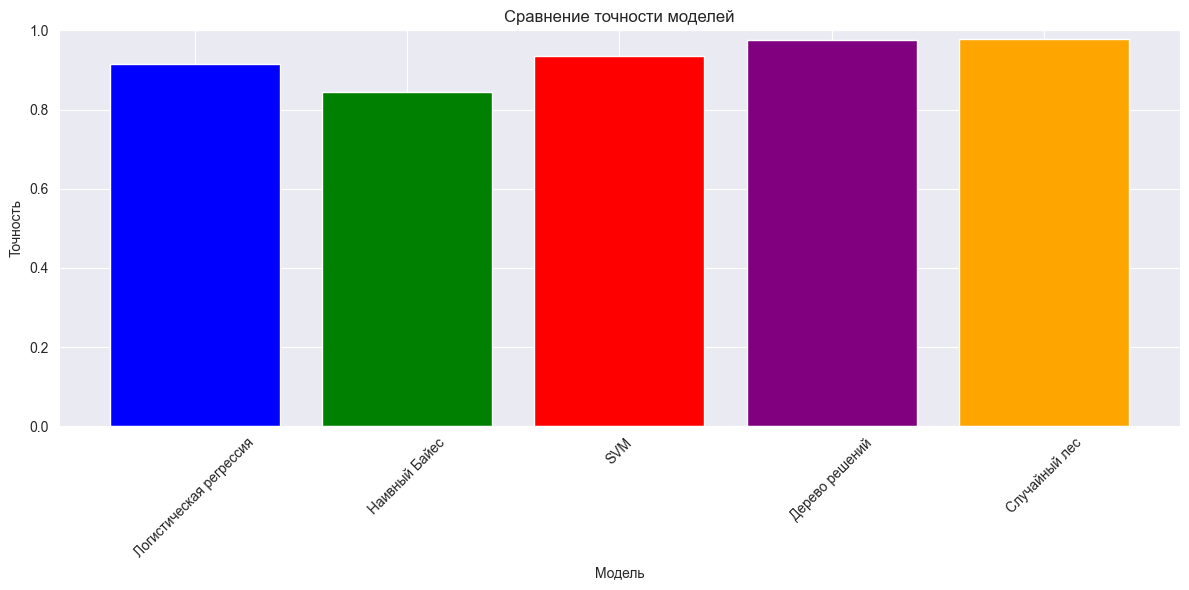

In [44]:
# сравнение всех моделей
models = ['Логистическая регрессия', 'Наивный Байес', 'SVM', 'Дерево решений', 'Случайный лес']
accuracies = [lr_accuracy, nb_accuracy, svm_accuracy, dt_accuracy, rf_accuracy]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.title('Сравнение точности моделей')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# наилучшая модель
best_model_idx = np.argmax(accuracies)
print(f"\nНаилучшая модель: {models[best_model_idx]} с точностью {round(accuracies[best_model_idx], 4)}")


Наилучшая модель: Случайный лес с точностью 0.9789


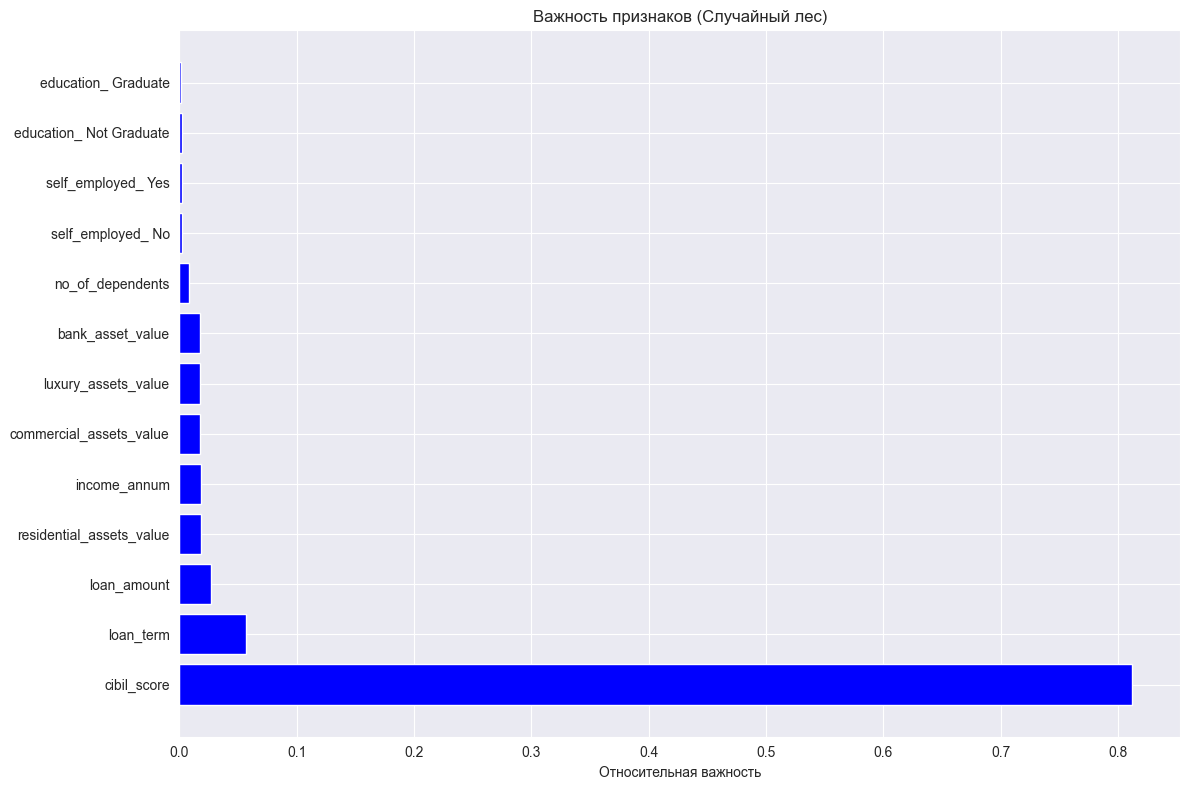

In [46]:
# проверка важности признаков для лучшей модели (если это дерево решений или случайный лес)
if best_model_idx in [3, 4]:
    model = dt_grid if best_model_idx == 3 else rf_grid
    X_transformed = model.best_estimator_.named_steps['preprocessor'].transform(X_train)

    importances = model.best_estimator_.named_steps['classifier'].feature_importances_

    ohe = model.best_estimator_.named_steps['preprocessor'].transformers_[1][1]
    cat_features = ohe.get_feature_names_out(categorical_cols)
    feature_names = numerical_cols + list(cat_features)

    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title(f'Важность признаков ({models[best_model_idx]})')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Относительная важность')
    plt.tight_layout()
    plt.show()